<h1><center></center></h1>
<h1><center>Elevvo Internship</center></h1>
<h1><center>Task 3</center></h1>
<h2><center>Fake News Detection</center></h2>

# **Hands on Task 3**


- We build a binary text classification pipeline using the Fake and Real News Dataset.
- We clean and preprocess the news articles (lowercasing, punctuation removal, stopwords, lemmatization).
- We apply `TF-IDF` to vectorize the article content.
- We train three Models: Logistic Regression, Support Vector Machine (SVM), and LSTM.
- Finally, we evaluate the three models and visualize word clouds and most frequent words for fake vs. real news.

# **1- Data Collection**

**Setup**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammedtaha778","key":"6a7ede5a84baa80af080f45a62197a14"}'}

**Move kaggle.json to the correct directory**

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Install Kaggle CLI**

In [4]:
!pip install kaggle --quiet

**Download the dataset using its Kaggle identifier**

In [5]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 473MB/s]


**Unzip the downloaded dataset**

In [6]:
!unzip fake-and-real-news-dataset.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


**Import**

In [7]:
import pandas as pd

**Read CSV's**

In [8]:
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

**Add labels**

In [9]:
df_fake["label"] = 0
df_real["label"] = 1

**Combine into one DF**

In [10]:
df_fake["content"] = df_fake["title"] + " " + df_fake["text"]
df_real["content"] = df_real["title"] + " " + df_real["text"]
df = pd.concat([df_fake[["content", "label"]], df_real[["content", "label"]]], ignore_index=True)

**Preview**

In [11]:
df[["content", "label"]].head()

,content,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [12]:
label_names = {0: "Fake", 1: "Real"}
df["category"] = df["content"].map(label_names)

**Preview data**

In [13]:
df[["content", "label", "category"]].head()

,content,label,category
0,Donald Trump Sends Out Embarrassing New Year’...,0,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,0,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,0,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,0,NaN


**Check classes balance**

In [14]:
df['label'].value_counts()

,count
label,
0,23481
1,21417


**Save CSV's**

In [15]:
df.to_csv("fake_news.csv", index=False)

# **2. Preprocessing**

**Import NLP preprocessing libraries (NLTK, regex)**

In [16]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

**Download NLTK resources (stopwords, tokenizer, lemmatizer)**

In [17]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

**Initialize stopword list and lemmatizer**

In [18]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

**Define text preprocessing function**

In [19]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(processed_tokens)

**Apply preprocessing to all reviews in train/test sets**

In [20]:
df['processed_text'] = df['content'].apply(preprocess_text)

df[['content', 'processed_text']].head()

,content,processed_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obamas name coded website ...
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...


**Remove duplicates to avoid data leakage**

In [21]:
df = df.drop_duplicates(subset='content').reset_index(drop=True)

**Split into train and test sets**

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

**Preview split data**

In [23]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train['label'].value_counts(), df_test['label'].value_counts()

Train shape: (31284, 4)
Test shape: (7821, 4)


(label
 1    16958
 0    14326
 Name: count, dtype: int64,
 label
 1    4239
 0    3582
 Name: count, dtype: int64)

# **3. Vectorization**

**Import TF-IDF vectorizer**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

**Initialize TF-IDF vectorizer**

In [25]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), min_df=5, max_df=0.8)

**Fit and transform training data**

In [26]:
X_train_vec = tfidf.fit_transform(df_train['processed_text'])

**Transform test data using the same vectorizer**

In [27]:
X_test_vec = tfidf.transform(df_test['processed_text'])

**Check shape**

In [28]:
print("TF-IDF Matrix (Train):", X_train_vec.shape)
print("TF-IDF Matrix (Test):", X_test_vec.shape)

TF-IDF Matrix (Train): (31284, 10000)
TF-IDF Matrix (Test): (7821, 10000)


# **4. Model Training & Evaluation**

**Import classification model and evaluation tools**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

**Train Logistic Regression model**

In [30]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression
logreg_params = {
    'C': [0.1, 0.5, 1, 5],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

grid_logreg = GridSearchCV(LogisticRegression(), logreg_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_logreg.fit(X_train_vec, df_train['label'])
logreg = grid_logreg.best_estimator_

print("Best Logistic Regression Params:", grid_logreg.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logistic Regression Params: {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


**Make predictions on the test set**

In [31]:
y_pred_logreg = grid_logreg.predict(X_test_vec)

**Evaluate using classification report**

In [32]:
print("Logistic Regression - Classification Report:")
print(classification_report(df_test['label'], y_pred_logreg, target_names=label_names.values()))

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      3582
        Real       0.99      1.00      0.99      4239

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



**Plot confusion matrix**

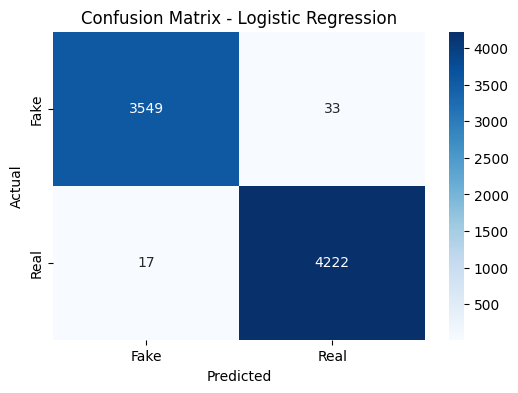

In [33]:
cm_logreg = confusion_matrix(df_test['label'], y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

**model accuracy**

In [34]:
acc_logreg = accuracy_score(df_test['label'], y_pred_logreg)
print(f"Logistic Regression Accuracy: {acc_logreg:.4f}")

Logistic Regression Accuracy: 0.9936


In [35]:
f1_logreg = f1_score(df_test['label'], y_pred_logreg)
print(f"Logistic Regression F1 Score: {f1_logreg:.4f}")

Logistic Regression F1 Score: 0.9941


**Train SVM model**

In [36]:
# SVM
svm_params = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced']
}

grid_svm = GridSearchCV(LinearSVC(), svm_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_svm.fit(X_train_vec, df_train['label'])
svm = grid_svm.best_estimator_

print("Best SVM Params:", grid_svm.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best SVM Params: {'C': 1, 'class_weight': 'balanced'}


**Make predictions on the test set**

In [37]:
y_pred_svm = grid_svm.predict(X_test_vec)

**Evaluate using classification report**

In [38]:
print("SVM - Classification Report:")
print(classification_report(df_test['label'], y_pred_svm, target_names=label_names.values()))

SVM - Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      3582
        Real       0.99      1.00      1.00      4239

    accuracy                           0.99      7821
   macro avg       1.00      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



**Plot confusion matrix**

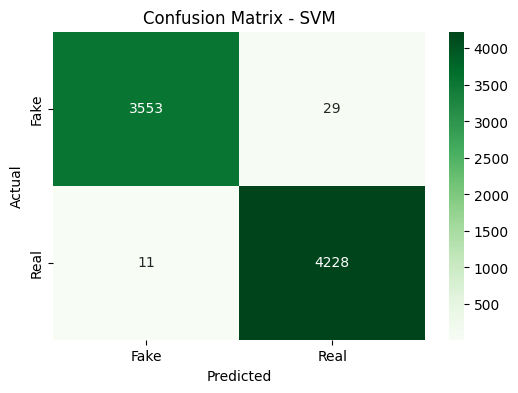

In [39]:
cm_svm = confusion_matrix(df_test['label'], y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Model accuracy**

In [40]:
acc_svm = accuracy_score(df_test['label'], y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.4f}")

SVM Accuracy: 0.9949


In [41]:
f1_svm = f1_score(df_test['label'], y_pred_svm)
print(f"SVM F1 Score: {f1_svm:.4f}")

SVM F1 Score: 0.9953


# **4.3 LSTM-Based Deep Learning Model (Keras)**

**Import Libraries**

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

**Prepare tokenizer**

In [43]:
vocab_size = 5000
oov_token = "<OOV>"
max_len = 500

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_train['processed_text'])

**Convert text to sequences**

In [44]:
X_train_seq = tokenizer.texts_to_sequences(df_train['processed_text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['processed_text'])

**Pad sequences**

In [45]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

**Labels**

In [46]:
y_train = df_train['label'].values
y_test = df_test['label'].values

**Define model**

In [47]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Compile model**

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**Train model**

In [49]:
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                    epochs=5, batch_size=64)

Epoch 1/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 867s 2s/step - accuracy: 0.5355 - loss: 0.6916 - val_accuracy: 0.4878 - val_loss: 0.6781
Epoch 2/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 913s 2s/step - accuracy: 0.5730 - loss: 0.6437 - val_accuracy: 0.8753 - val_loss: 0.4107
Epoch 3/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 877s 2s/step - accuracy: 0.8453 - loss: 0.4066 - val_accuracy: 0.8971 - val_loss: 0.3316
Epoch 4/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - accuracy: 0.8633 - loss: 0.3701 - val_accuracy: 0.8381 - val_loss: 0.3924
Epoch 5/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.7962 - loss: 0.4436 - val_accuracy: 0.9343 - val_loss: 0.2035


**Evaluate model**

In [50]:
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

245/245 ━━━━━━━━━━━━━━━━━━━━ 51s 206ms/step


**classification report**

In [51]:
print("\nLSTM - Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_names.values()))


LSTM - Classification Report:
              precision    recall  f1-score   support

        Fake       0.89      0.98      0.93      3582
        Real       0.98      0.89      0.94      4239

    accuracy                           0.93      7821
   macro avg       0.94      0.94      0.93      7821
weighted avg       0.94      0.93      0.93      7821



**Confusion Matrix**

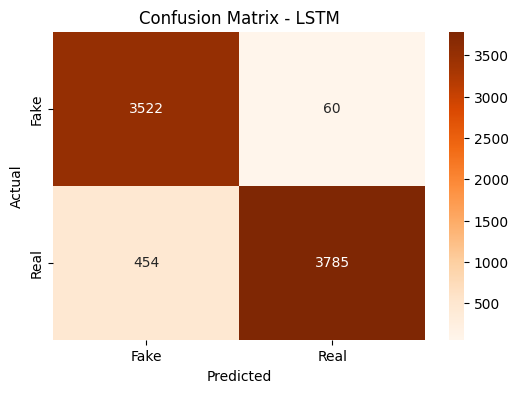

In [52]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Accuracy**

In [53]:
acc_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Accuracy: {acc_lstm:.4f}")

LSTM Accuracy: 0.9343


In [54]:
f1_lstm = f1_score(y_test, y_pred_lstm)
print(f"LSTM F1 Score: {f1_lstm:.4f}")

LSTM F1 Score: 0.9364


**Accuracy and F1 Comparison along the 3 models**

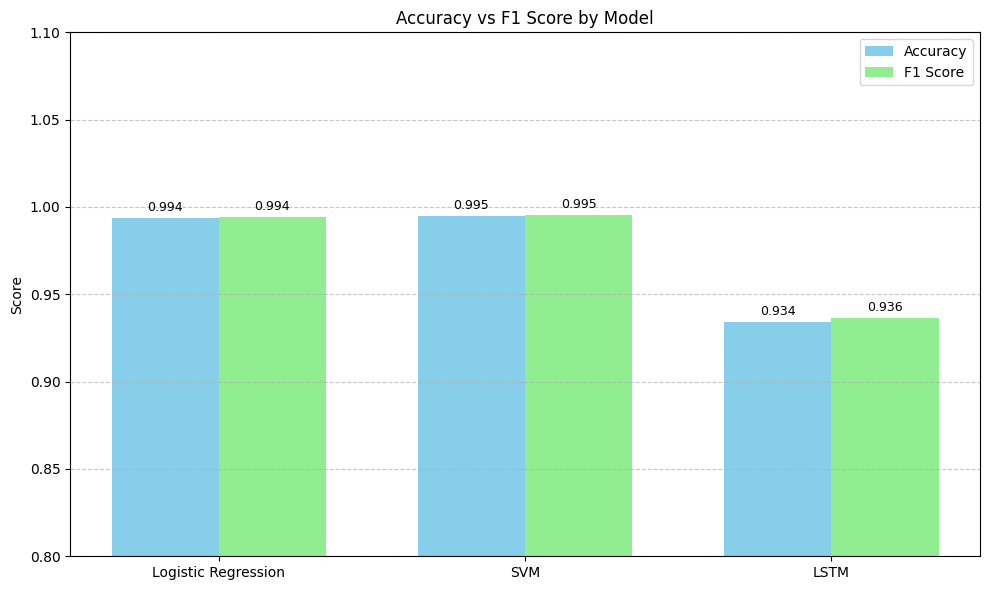

In [58]:
import numpy as np
accuracy_scores = [acc_logreg, acc_svm, acc_lstm]
f1_scores = [f1_logreg, f1_svm, f1_lstm]

model_names = ["Logistic Regression", "SVM", "LSTM"]
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Accuracy vs F1 Score by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0.8, 1.1)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **5. Bonus: Word Cloud Visualization**

**Import WordCloud library**

In [59]:
from wordcloud import WordCloud

**Generate and display word clouds for each category**

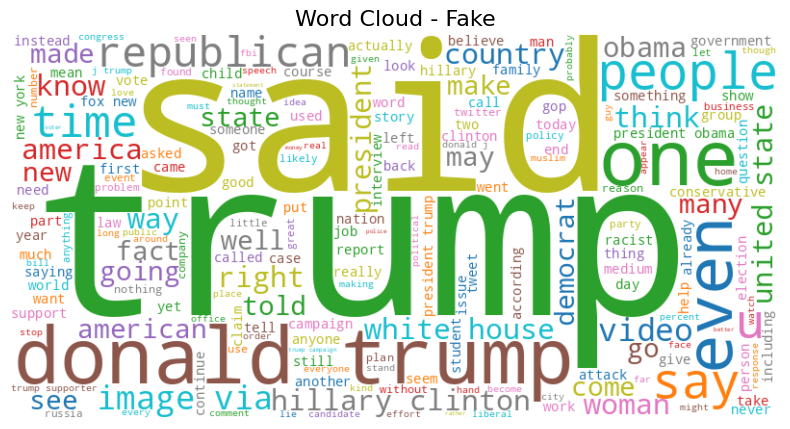

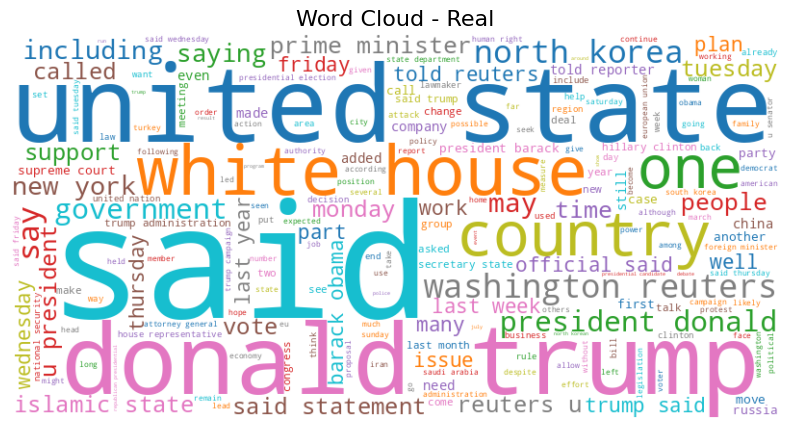

In [60]:
for label, category in label_names.items():
    # Concatenate all processed texts for this category
    category_text = " ".join(df_train[df_train["label"] == label]["processed_text"])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="tab10").generate(category_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {category}", fontsize=16)
    plt.show()

# **5.1 Bonus: Bar Plots of Most Frequent Words per Category**

**Import supporting libraries**

In [61]:
from collections import Counter
import numpy as np

**function to extract top N frequent words per category**

In [62]:
def get_top_n_words(texts, n=20):
    all_words = " ".join(texts).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

**Generate bar plots per category**

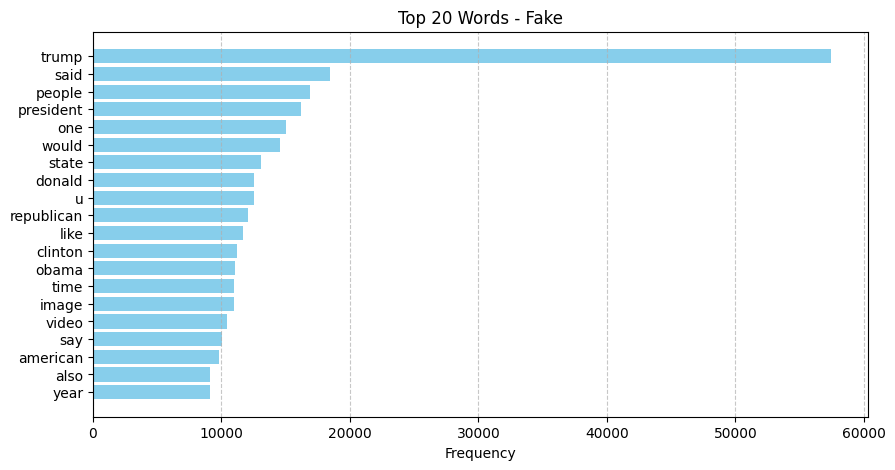

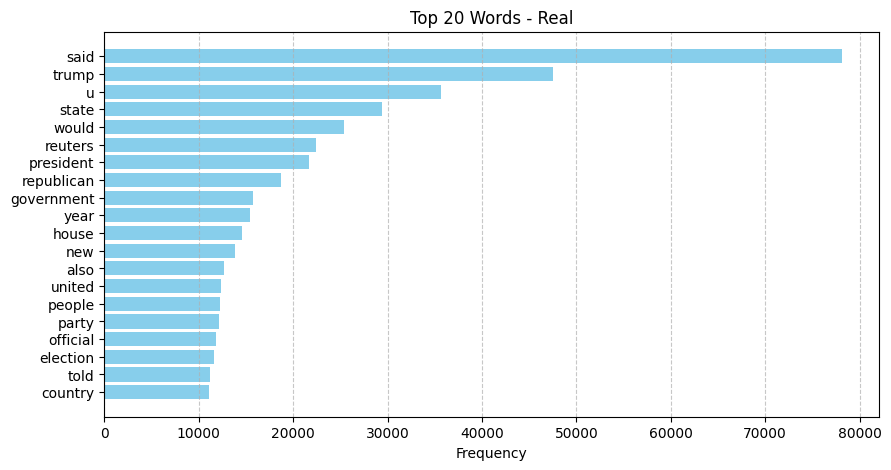

In [63]:
for label, category in label_names.items():
    # Get processed texts for this category
    texts = df_train[df_train['label'] == label]['processed_text']

    top_words = get_top_n_words(texts, n=20)

    # Separate words and counts
    words, counts = zip(*top_words)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.title(f"Top 20 Words - {category}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# **6. Summary & Save Outputs**

**Save Preprocessed Datasets**

In [64]:
df_train.to_csv("fake_news_train_processed.csv", index=False)
df_test.to_csv("fake_news_test_processed.csv", index=False)
print("Preprocessed datasets saved.")

Preprocessed datasets saved.


**Save Logistic Regression Model and TF-IDF Vectorizer**

In [65]:
import joblib

joblib.dump(logreg, "logistic_regression_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Scikit-learn model and TF-IDF vectorizer saved.")

Scikit-learn model and TF-IDF vectorizer saved.


**Save Word Clouds as Image Files**

In [66]:
from wordcloud import WordCloud

for label, category in label_names.items():
    category_text = " ".join(df_train[df_train["label"] == label]["processed_text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(category_text)
    wordcloud.to_file(f"wordcloud_{category.lower()}.png")

print("Word cloud images saved.")

Word cloud images saved.


**Save SVM Model**

In [67]:
joblib.dump(svm, "svm_model.pkl")
print(" SVM model saved.")

 SVM model saved.


**Save LSTM model & tokenizer**

In [68]:
model.save("lstm_model.keras")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("LSTM model and tokenizer saved.")

LSTM model and tokenizer saved.


## **Final Summary and Reflections**

Throughout this project, the goal was to build a robust fake news detection system capable of distinguishing between real and fake news articles using machine learning and deep learning models.

### 🛠️ Model Development Journey

Several modeling strategies were explored:

- **Logistic Regression with TF-IDF**: Served as the initial baseline. While it performed decently on training data, it struggled with generalizing to more nuanced or factually dense articles.
  
- **Support Vector Machine (SVM)**: Added for its known strength in high-dimensional text data. It performed slightly better on balanced classes but still misclassified many real articles as fake when phrasing was neutral or vague.
  
- **LSTM Neural Network**: To overcome the limitations of TF-IDF and introduce sequence learning, an LSTM model was implemented. This model architecture was **adapted multiple times**, and **dataset parameters were tuned repeatedly** to improve generalization.

In an effort to achieve better results, I also:
- Revisited preprocessing several times to test whether changing tokenization, stopword filtering, or lemmatization would help.
- Modified the number of epochs, embedding dimensions, and sequence lengths.
- Tried using different train/test splits and class balances.
- **Reviewed and replicated one of the top-rated LSTM notebooks on Kaggle**, following the same architecture, hyperparameters, and tokenizer structure yet still encountered persistent misclassifications.

### ⚠️ Limitations and Realizations

Despite all efforts, a significant number of misclassifications persisted. The main challenges became clear:

- **Dataset ambiguity**: Some real articles, especially financial or neutral reports, resemble fake articles in tone.
- **Lack of semantic understanding**: TF-IDF-based models and even LSTM, without pretrained embeddings, fail to grasp the underlying context.
- **Overfitting risk**: Small dataset size and repetitive patterns caused models to overfit easily, yet fail to generalize.

### ✅ Final Note

The pipeline reflects a solid end-to-end implementation including text preprocessing, model comparison, deployment, and interpretability. However, this real-world scenario reinforces the understanding that **no amount of tweaking a model can overcome fundamental dataset or task limitations** without introducing better semantic knowledge (e.g., transformer-based models like BERT) or significantly more diverse and labeled data.

The project highlights not just technical proficiency but also the **ability to pivot, experiment, evaluate failure points, and learn** which is a critical part of any real-world machine learning journey.
